### Juan David Orjuela - Sofía Álvarez López

In [62]:
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
#from keras import regularizers
from sklearn import preprocessing 
from sklearn.pipeline import Pipeline
pd.options.mode.chained_assignment = None
from tensorflow.keras.layers import Dense 
from scipy.stats import percentileofscore
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

<h1 align='center'>Laboratorio 4: Machine Learning Techniques</h1>

## Problema 2

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

Fuente de Datos: https://www.kaggle.com/mlg-ulb/creditcardfraud


### 2.1 Exploración de los datos

Kaggle nos informa que los datos corresponden a transacciones de tarjeta de crédito hechas durante dos días en Septiembre de 2013 por tarjetahabientes europeos. Es un conjunto altamente desbalanceado, con sólo el 0.172% correspondiente a transacciones fraudulentas. Por motivos de confidencialidad, los datos se han tranformado mediante un PCA (28 componentes), exceptuando "Time" y "Amount", que corresponden al tiempo en segundos entre cada transacción y la primera transacción del set de datos, y al monto de la transacción respectivamente. La variable "Class" es la variable de clasificación, y corresponde a 1 en caso de fraude o a 0 en caso contrario.

Leamos nuestros datos y miremos una muestra aleatoria de 5 transacciones:

In [2]:

df=pd.read_csv("creditcard.csv")
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
183895,126001.0,1.636265,-0.627242,-2.017722,0.501029,0.119878,-0.674758,0.295816,-0.190633,1.058547,...,-0.135546,-0.638784,0.038003,0.485716,-0.131962,-0.132216,-0.049835,0.018696,214.14,0
10622,17816.0,1.039608,-0.542638,1.042711,0.345131,-1.037927,0.062147,-0.816209,0.124539,2.049801,...,-0.004546,0.127592,-0.136774,0.032591,0.148748,1.065617,-0.087370,0.008992,93.85,0
72230,54622.0,0.768498,-2.071528,-0.351640,-1.268925,-1.200014,0.154110,-0.444299,-0.007067,-2.341259,...,0.102282,-0.041901,-0.272510,-0.274883,0.253534,-0.138536,-0.025921,0.053022,347.96,0
84235,60218.0,-1.501118,0.561567,1.814831,0.908967,-0.117288,0.490726,-0.050950,0.486975,-0.340270,...,0.014665,0.263669,0.180554,-0.610094,0.564097,-0.194955,-0.020241,-0.054078,64.35,0
171579,120706.0,-0.532100,-0.550413,-1.053912,-0.809029,-0.372126,-1.136331,0.135403,0.093269,-0.775935,...,0.297177,1.151058,0.703472,-0.061065,-0.133235,0.008850,-0.046612,-0.167229,119.00,0


Ahora, revisamos si hay algún dato nulo en nuestro conjunto de datos. Notamos que el "máximo" de nulos es 0: es decir, ¡no hay nulos en el conjuntos de datos!

In [3]:
print('Cantidad de nulos:', df.isnull().sum().max())

Cantidad de nulos: 0


Asimismo, revisamos que, en efecto, las clases que hay corresponden a 0 (transacción corriente) y 1 (fraude).

In [4]:
print(f"Las clases presentes en el data set son: {np.unique(df['Class'])}" )

Las clases presentes en el data set son: [0 1]


Ahora, veamos qué tan desbalanceadas están las clases. Esperamos que haya gran desbalance, pues las transacciones fraudulentas son pocas, pero pueden representan pérdidas de millones de dólares anuales.

In [5]:
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


O, gráficamente, tenemos que:

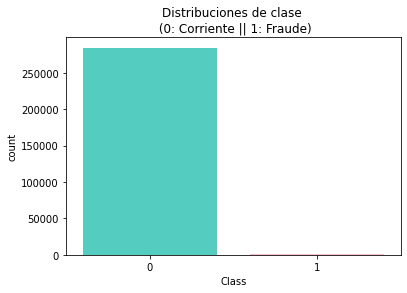

In [6]:
sns.countplot('Class', data=df, palette=['turquoise', 'lightpink'])
plt.title('Distribuciones de clase \n (0: Corriente || 1: Fraude)')
plt.show()

Son tan poquitas transacciones fraudulentas (únicamente el 0.17%) que prácticamente es despreciable en la gráfica de arriba.

Ahora, veamos una descripción estadística de las variables del PCA que se nos ha dado:

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Notamos que la media de casi todos los componentes que provienen del PCA, como esperamos por construcción, es cercana a 0, dado que todos son del orden de $10^{-15}$ y $10^{-16}$. Asimismo, podemos apreciar que la transacción promedio tarda 94.813 ms y el monto promedio por transacción es 88.3 euros. No hay mucha más información que podamos rescatar de esto, pues las 28 variables son las componentes principales del PCA realizado.  

Ahora, veamos si tenemos datos duplicados:

In [8]:
df.duplicated().sum()

1081

Porcentualmente, esto es:

In [9]:
print(np.round(100*df.duplicated().sum()/df.shape[0], 2))

0.38


Y, para la clase positiva,

In [10]:
print(np.round(100*((df["Class"]*df.duplicated()).sum())/df["Class"].sum(), 2))

3.86


Podemos ver que solo el 0.38% de los datos están duplicados, y que 3.86% de los duplicados corresponden a la clase positiva. En realidad, es un porcentaje muy bajo. Debido a que no tenemos el conjunto de datos original, a qué se refiere o cómo se tomaron los datos, es difícil saber si es un error espurio de la adquisición de los datos o si, en efecto, así fueron las transacciones. Por lo tanto, no consideramos pertinente quitar estos datos.

Ahora, veamos las distribuciones (en histogramas) de cada una de las variables que estamos estudiando. 

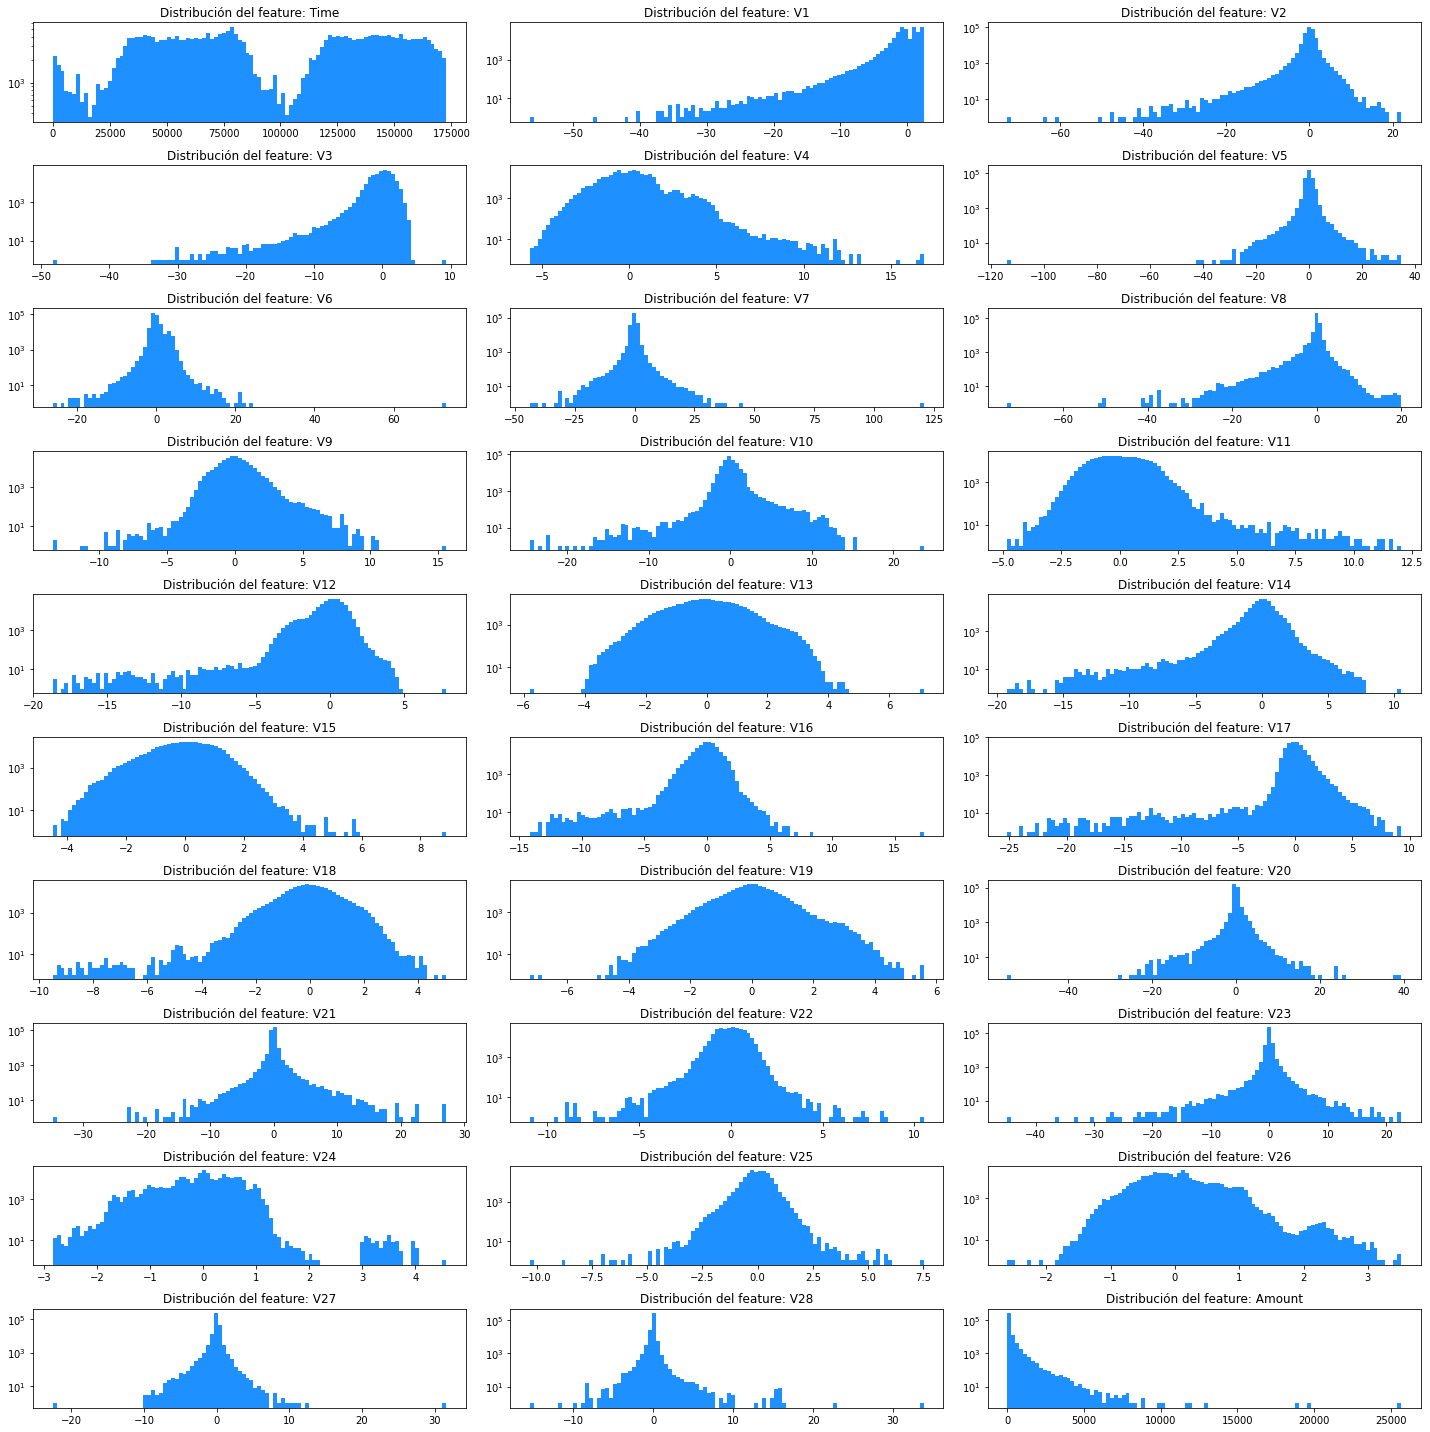

In [11]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=100,ax=ax,facecolor='dodgerblue')
        ax.set_title('Distribución del feature: ' + feature)
        ax.set_yscale('log')
        ax.grid(False)
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.drop('Class', axis=1).columns,10,3)

Se graficó en escala logarítmica en y para lograr observar los valores pequeños. Para la variable del tiempo se obtiene una distribución correspondiente a una serie de tiempo de periodo de un día. Es altamente probable que los valles correspondan a las horas de la madrugada, cuando se realizan considerablemente menos transacciones. 

Como habíamos dicho previamente, note que todas las ditribuciones están centradas en 0, como es de esperarse.

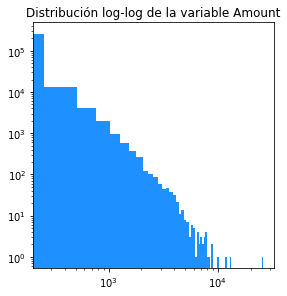

In [12]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
df["Amount"].hist(bins=100,ax=ax,facecolor='dodgerblue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(False)
fig.tight_layout() 
plt.title('Distribución log-log de la variable Amount')
plt.show()

Por el lado del monto, se observa un comportamiento cercano a una ley de potencias (se caracteriza visualmente como una recta en una gráfica log-log), similar a la ley de Zipf o correspondiente con el principio de Pareto, algo que de alguna manera se espera: la mayoría de las transacciones son de montos pequeños y hay muy pocas de montos exorbitantes. Vemos ahora la correlación entre nuestras variables:

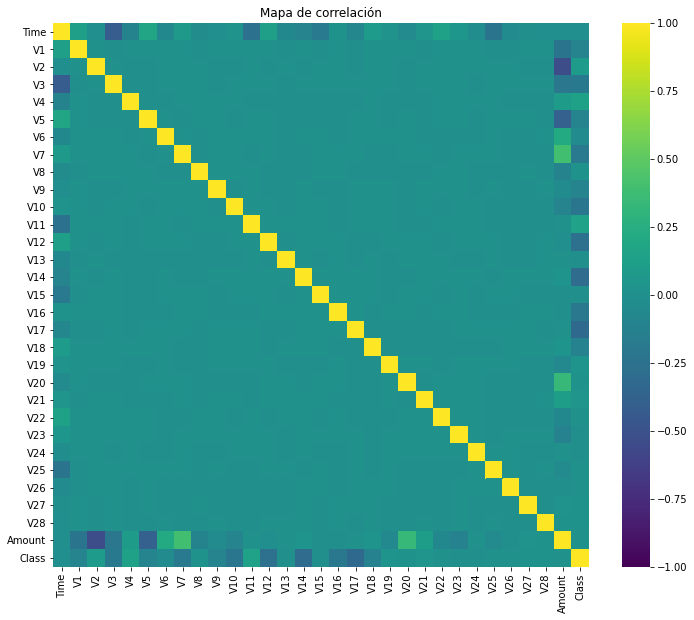

In [14]:
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr,vmin=-1.0,vmax=1.0,cmap="viridis")
plt.title('Mapa de correlación')
plt.show()

Como es de esperarse, por construcción, la correlación es cercana a cero entre los features del PCA, entonces lo realmente interesante sería observar las otras columnas. Se observa una anticorrelación interesante entre "Amount" y el V2 y un poco el V5 también. También hay una ligera anticorrelación entre "Time" y V3.

Ahora separamos nuestro conjuntos entre fraude y no-fraude y y re-escalamos usando la desviación estándar las variables que no han sido re-escaladas mediante el PCA, es decir las corresponientes a "Time" y "Amount". Luego construimos nuestro primer autoencoder. Procedemos a distribuir los datos de la clase normal entre entrenamiento y validación, y la clase de fraude entre una clase de validación y prueba. 

Usaremos los mismo Callbacks que se aplicaron en el primer problema, a saber "Early Stopping" y "Tensorboard".

### 2.2 Particiones y preprocesamiento
Lo primero que hacemos es separar el target de las features, como vemos a continuación:

In [15]:
x = df.drop(["Class"], axis=1)
y = df["Class"].values

Ahora, separamos los datos entre normal y fraude:

In [16]:
x_normal, x_fraude = x[y == 0], x[y == 1]

Lo siguiente que hacemos es partir el conjunto de datos entre entrenamiento y validación. Como vamos a construir un autoencoder para la reconstrucción de anomalías, lo que debemos hacer es entrenar únicamente con los datos normales. Note que también tomamos un conjunto para realizar la validación de nuestro modelo (i.e. de la reconstrucción de transacciones normales).

No obstante, también partimos el conjunto de fraudes en dos. <code>X_fraude_train</code> lo utilizamos para ver (aún en entrenamiento) si efectivamente se detectan como anomalías las transacciones fraudulentas.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(x_normal, np.ones(len(x_normal)), test_size=0.2, random_state=28)
X_fraude_train, X_fraude_test, y_fraude_train, y_fraude_test = train_test_split(x_fraude, np.ones(len(x_fraude)), test_size=0.2, random_state=28)

Ahora, seguimos con el preprocesamiento. Lo primero que hacemos es estandarizar (usando un StandardScaler()) las dos variables que no fueron escaladas durante el PCA: Amount y Time.

In [18]:
# Para x_train
X_train['Time'] = StandardScaler().fit_transform(X_train['Time'].values.reshape(-1, 1))
X_train['Amount'] = StandardScaler().fit_transform(X_train['Amount'].values.reshape(-1, 1))
# Para X_fraude_train
X_fraude_train['Time'] = StandardScaler().fit_transform(X_fraude_train['Time'].values.reshape(-1, 1))
X_fraude_train['Time'] = StandardScaler().fit_transform(X_fraude_train['Time'].values.reshape(-1, 1))

# Para x_val
X_val['Time'] = StandardScaler().fit_transform(X_val['Time'].values.reshape(-1, 1))
X_val['Amount'] = StandardScaler().fit_transform(X_val['Amount'].values.reshape(-1, 1))

# Los de test los haremos antes de despliegue.

### 2.3 Modelamiento
#### 2.3.1 Primer modelo baseline

Construiremos nuestros autoencoders usando una arquitectura que va reduciendo paulatinamente el número de neuronas, pasando de 30 a 16 y luego a 8 (capa latente), para luego aumentar de nuevo a 16 y 30, cuando reconstruye la entrada. Primeramente exploraremos activación de tangente hiperbólica para las capas ocultas intermedias con activación ReLu para la capa latente y la capa de salida. También probaremos exclusivamente activación ReLu que finaliza con función sigmoide para la capa de salida.

In [19]:
input_size = len(X_train.columns)
#Inicializamos el modelo
autoencoder = Sequential(name="Autoencoder_1")

#Encoder
autoencoder.add(Dense(30, activation='tanh', input_dim = input_size)) 
autoencoder.add(Dense(16, activation='tanh'))
autoencoder.add(Dense(8, activation='relu'))

#Decoder
autoencoder.add(Dense(16, activation='tanh'))
autoencoder.add(Dense(30, activation='tanh'))
autoencoder.add(Dense(input_size, activation='relu'))

Ahora compilamos el modelo. Debido a que tenemos un autoencoder (i.e. una tarea de regresión), usamos como función de pérdida el error cuadrático medio. Asimismo, por las mismas razones que justificamos en el problema 1, utilizamos el optimizador Adam. Finalmente, como métrica utilizamos el mismo error cuadrático medio (ya que este usamos como función de pérdida y es una de las mejores métricas en problemas de regresión).

In [20]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Veamos cómo va nuestro modelo:

In [21]:
autoencoder.summary()

Model: "Autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
Total params: 3,146
Trainable params: 3,146
Non-trainable params: 0
___________________________________________________

De manera similar al problema 1, definimos y utilizamos los mismos callbacks:

In [22]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None,)
callbacks = [early_stopping,tensorboard_callback]

Ahora sí, hacemos fit a nuestro autoencoder. Tomamos un batch de 1000 (tan grande como sea posible).

In [23]:
history_1 = autoencoder.fit(X_train, X_train, batch_size = 1000, epochs = 100, shuffle = True, callbacks=callbacks)    

Epoch 1/100
228/228 [==============================] - 1s 2ms/step - loss: 0.9070 - mean_squared_error: 0.9070
Epoch 2/100
228/228 [==============================] - 0s 1ms/step - loss: 0.7762 - mean_squared_error: 0.7762
Epoch 3/100
228/228 [==============================] - 0s 1ms/step - loss: 0.7252 - mean_squared_error: 0.7252
Epoch 4/100
228/228 [==============================] - 0s 1ms/step - loss: 0.7056 - mean_squared_error: 0.7056
Epoch 5/100
228/228 [==============================] - 0s 1ms/step - loss: 0.6944 - mean_squared_error: 0.6944
Epoch 6/100
228/228 [==============================] - 0s 1ms/step - loss: 0.6868 - mean_squared_error: 0.6868
Epoch 7/100
228/228 [==============================] - 0s 1ms/step - loss: 0.6812 - mean_squared_error: 0.6812
Epoch 8/100
228/228 [==============================] - 0s 1ms/step - loss: 0.6768 - mean_squared_error: 0.6768
Epoch 9/100
228/228 [==============================] - 0s 1ms/step - loss: 0.6730 - mean_squared_error: 0.6730
E

Ya que entrenamos el modelo, podemos ver el error cuadrático medio para cada característica. Para poder visualizar esto, utilizamos el método <code>predict</code> sobre los datos de entrenamiento y validación. Para los de entrenamiento, lo que queremos, en realidad, es la salida de la última capa de la red que acabamos de construir. Los de validación no los ha visto el modelo y nos permitirá ver si se está haciendo overfitting sobre los datos de entrenamiento. 

Asimismo, queremos ver el error cuadrático medio sobre las instancias que queremos clasificar como anómalas (i.e. los fraudes). Estas también las predecimos y les calculamos el error cuadrático medio.

In [24]:
norm_train_recons=autoencoder.predict(X_train)
norm_val_recons=autoencoder.predict(X_val)
fraud_recons=autoencoder.predict(X_fraude_train)

Calculamos el MSE. Esto nos da un dataframe con el MSE para cada feature, para train, validación y los fraudes de entrenamiento.

In [25]:
mse_train = (np.square(norm_train_recons - X_train))
mse_val = (np.square(norm_val_recons - X_val))
mse_fraud = (np.square(fraud_recons - X_fraude_train))

Para observar la capacidad del autoencoder de reconstruir los features, obervamos la distribución del error cuadrático para cada componente. En las gráficas a continuación, los histogramas rosados corresponden a validación, los turquesa a entrenamiento y los azules a fraude.

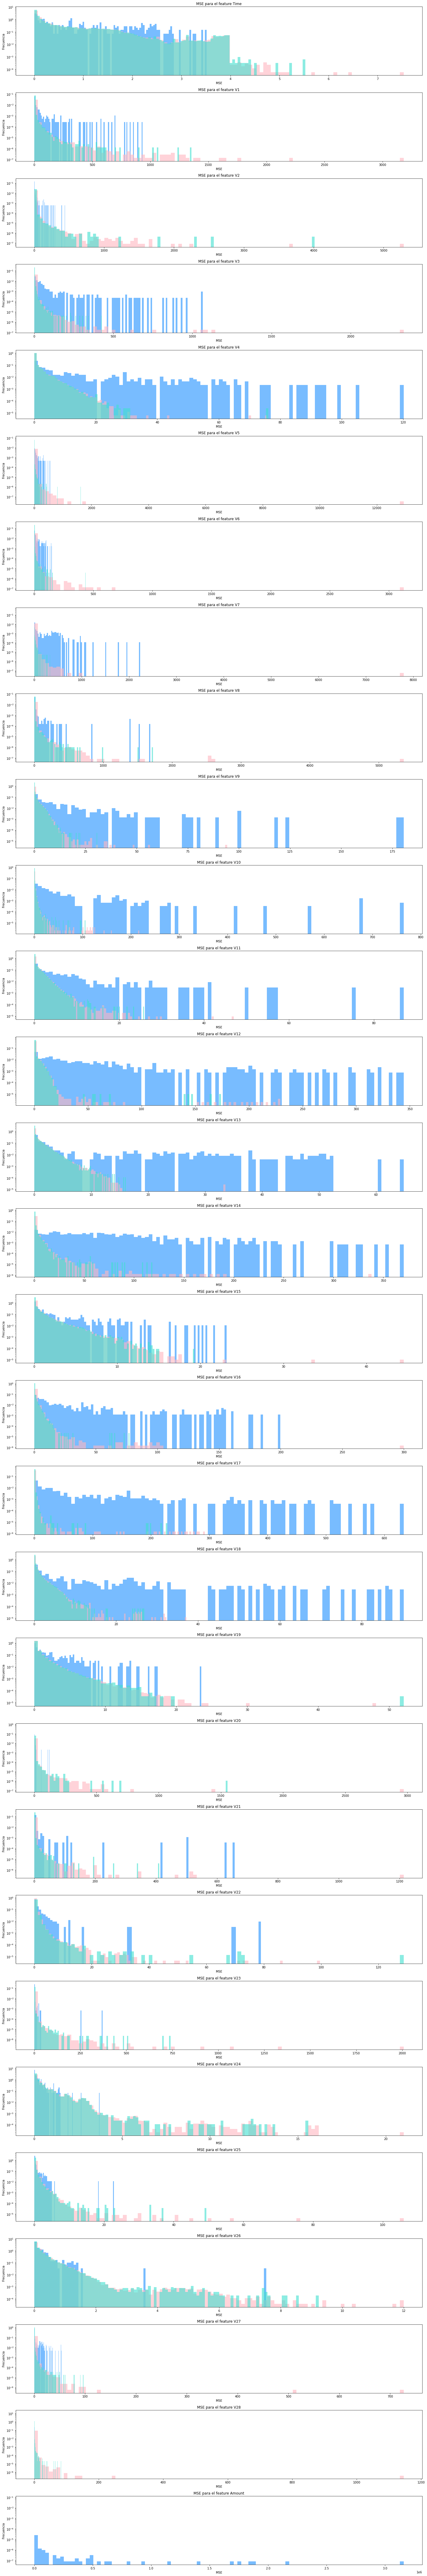

In [26]:
def draw_histograms(dataframe1, dataframe2, dataframe3, features, rows, cols):
    fig=plt.figure(figsize=(20,120))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe3[feature].hist(bins=100,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True)
        dataframe1[feature].hist(bins=100,ax=ax,facecolor='lightpink',alpha=0.6,density=True)
        dataframe2[feature].hist(bins=100,ax=ax,facecolor='turquoise',alpha=0.6,density=True)
        ax.set_title("MSE para el feature " + feature)
        ax.set_yscale('log')
        plt.ylabel('Frecuencia')
        plt.xlabel('MSE')
        ax.grid(False)
    fig.tight_layout()  
    plt.show()

draw_histograms(mse_train, mse_val, mse_fraud, mse_train.columns,30,1)

Vemos que en general pareciera que el autoencoder reconstruye mejor los componentes para la clase de transacciones normales: para la mayoría de features, tanto en entrenamiento como en validación, no sólo los errores obtenidos son similares (como esperamos de una situación de no overfitting) sino que, además, son bajos con respecto a los de transacciones fraudulentas.

Desde aquí podemos ver que, a priori, hay algunas features que ayudan a detectar mejor las transacciones fraudulentas que otras. Esto pues una mayor cantidad de transacciones fraudulentas terminó con errores cuadráticos medios bastante mayores. Estas son: Time, V9, V10, V11, V12, V14, V16, V17, V18 y Amount.

Veamos entonces la distribución del error cuadrático total sobre el conjunto de entrenamiento y validación de la clase mayoritaria y el conjunto de validación de la clase de fraude. El código de color es el mismo de arriba. Rosado para validación (i.e. transacciones corrientes con las que el modelo no fue entrenado), turquesa para entrenamiento y azul para datos fraudulentos.

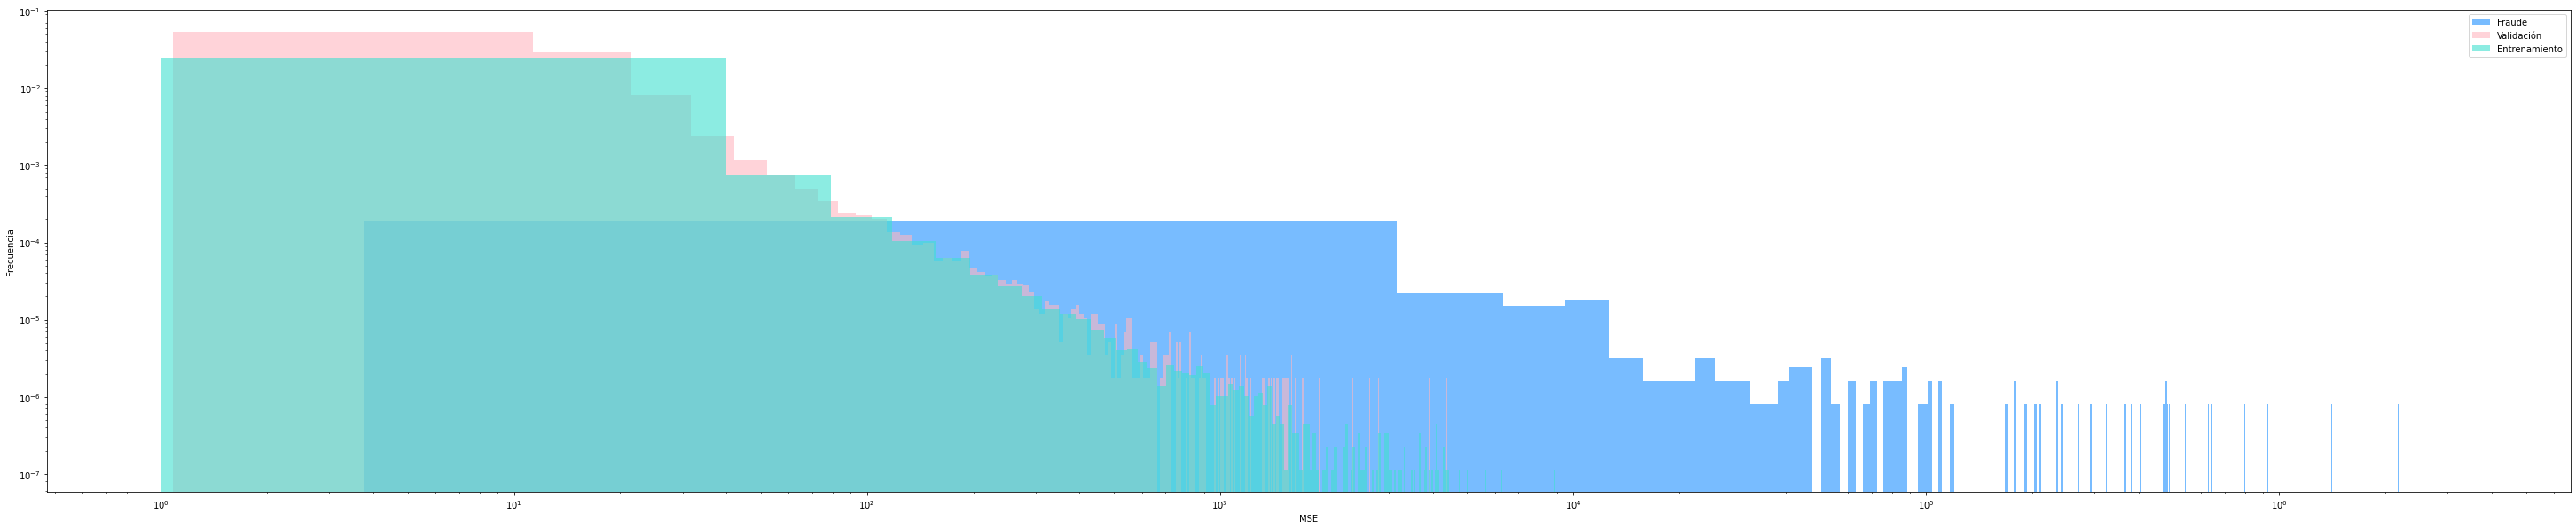

In [87]:
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,1,1)
mse_fraud.sum(axis=1).hist(bins=1000,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True,label='Fraude')
mse_val.sum(axis=1).hist(bins=1000,ax=ax,facecolor='lightpink',alpha=0.6,density=True,label='Validación')
mse_train.sum(axis=1).hist(bins=1000,ax=ax,facecolor='turquoise',alpha=0.6,density=True,label='Entrenamiento')
plt.ylabel('Frecuencia')
plt.xlabel('MSE')
plt.yscale('log')
plt.xscale('log')
ax.grid(False)
plt.legend()
plt.show()

Para poder visualizar bien, hacemos una gráfica log-log. Note que, en promedio, los errores asociados a la clase mayoritaria (tanto en entrenamiento como en validación) son bastante pequeños (y siguen la misma tendencia - no estamos haciendo overfitting -) comparados con los de las transacciones fraudulentas. Más aún note que, a partir de cierto valor (aproximadamente $10^2 = 100$), la cantidad de transacciones fraudulentas es mayor que las no fraudulentas. Si determináramos este como nuestro threshold, entonces definitivamente tenemos un gran rango hacia arriba de MSE que nos permite catalogar una transacción como fraudulenta.  

Ahora, podemos ver que el porcentaje de transacciones no fraudulentas cuyo error cuadrático medio en entrenamiento es mayor a 100 es:

In [122]:
print('En entrenamiento: ','{} %'.format(np.round(100*len(mse_train[mse_train.sum(axis=1) >= 100])/len(mse_train),2)))

print('En validación: ','{} %'.format(np.round(100*len(mse_val[mse_val.sum(axis=1) >= 100])/len(mse_val),2)))

En entrenamiento:  1.7 %
En validación:  1.76 %


Apenas un 0.06% de diferencia: otro argumento para decir que no está haciendo overfitting.  En cambio, el porcentaje de transacciones fraudulentas con MSE mayor a 100 es:

In [123]:
print('Fraudulentas: ','{} %'.format(np.round(100*len(mse_fraud[mse_fraud.sum(axis=1) >= 100])/len(mse_fraud),2)))

Fraudulentas:  90.84 %


Vemos que, si definimos el corte en MSE$=100$, el 90.84% de las transacciones fraudulentas se catalogan como tal. Este es un porcentaje bastante bueno, considerando que, además, menos del 2% de las transacciones no fraudulentas se están clasificando como fraudulentas (falsos positivos). 

#### 2.3.2 Segundo modelo baseline
Nuestro segundo modelo baseline considera el uso de funciones de activación ReLu en todas sus capas, excepto en la última, donde utilizaremos una función sigmoide.

In [28]:
input_size = len(X_train.columns)
#Inicializamos el modelo
autoencoder_2 = Sequential(name="Autoencoder_2")

#Encoder
autoencoder_2.add(Dense(30, activation='relu', input_dim = input_size)) 
autoencoder_2.add(Dense(16, activation='relu'))
autoencoder_2.add(Dense(8, activation='relu'))

#Decoder
autoencoder_2.add(Dense(16, activation='relu'))
autoencoder_2.add(Dense(30, activation='relu'))
autoencoder_2.add(Dense(input_size, activation='sigmoid'))

Escogemos la misma métrica, optimizador y pérdida:

In [29]:
autoencoder_2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [30]:
autoencoder_2.summary()

Model: "Autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
Total params: 3,146
Trainable params: 3,146
Non-trainable params: 0
___________________________________________________

Ahora sí, hacemos fit a nuestro autoencoder. Tomamos un batch de 500 (tan grande como sea posible).

In [31]:
history_2 = autoencoder_2.fit(X_train, X_train, batch_size = 500, epochs = 100, shuffle = True, callbacks=callbacks)    

Epoch 1/100
455/455 [==============================] - 1s 1ms/step - loss: 0.9661 - mean_squared_error: 0.9661
Epoch 2/100
455/455 [==============================] - 0s 966us/step - loss: 0.8616 - mean_squared_error: 0.8616
Epoch 3/100
455/455 [==============================] - 0s 1ms/step - loss: 0.8430 - mean_squared_error: 0.8430
Epoch 4/100
455/455 [==============================] - 0s 986us/step - loss: 0.8341 - mean_squared_error: 0.8341
Epoch 5/100
455/455 [==============================] - 0s 993us/step - loss: 0.8247 - mean_squared_error: 0.8247
Epoch 6/100
455/455 [==============================] - 0s 1ms/step - loss: 0.8182 - mean_squared_error: 0.8182
Epoch 7/100
455/455 [==============================] - 0s 1ms/step - loss: 0.8102 - mean_squared_error: 0.8102
Epoch 8/100
455/455 [==============================] - 0s 1ms/step - loss: 0.8054 - mean_squared_error: 0.8054
Epoch 9/100
455/455 [==============================] - 0s 1ms/step - loss: 0.8030 - mean_squared_error: 0.

Veamos la distribución del error cuadrático medio para este modelo:

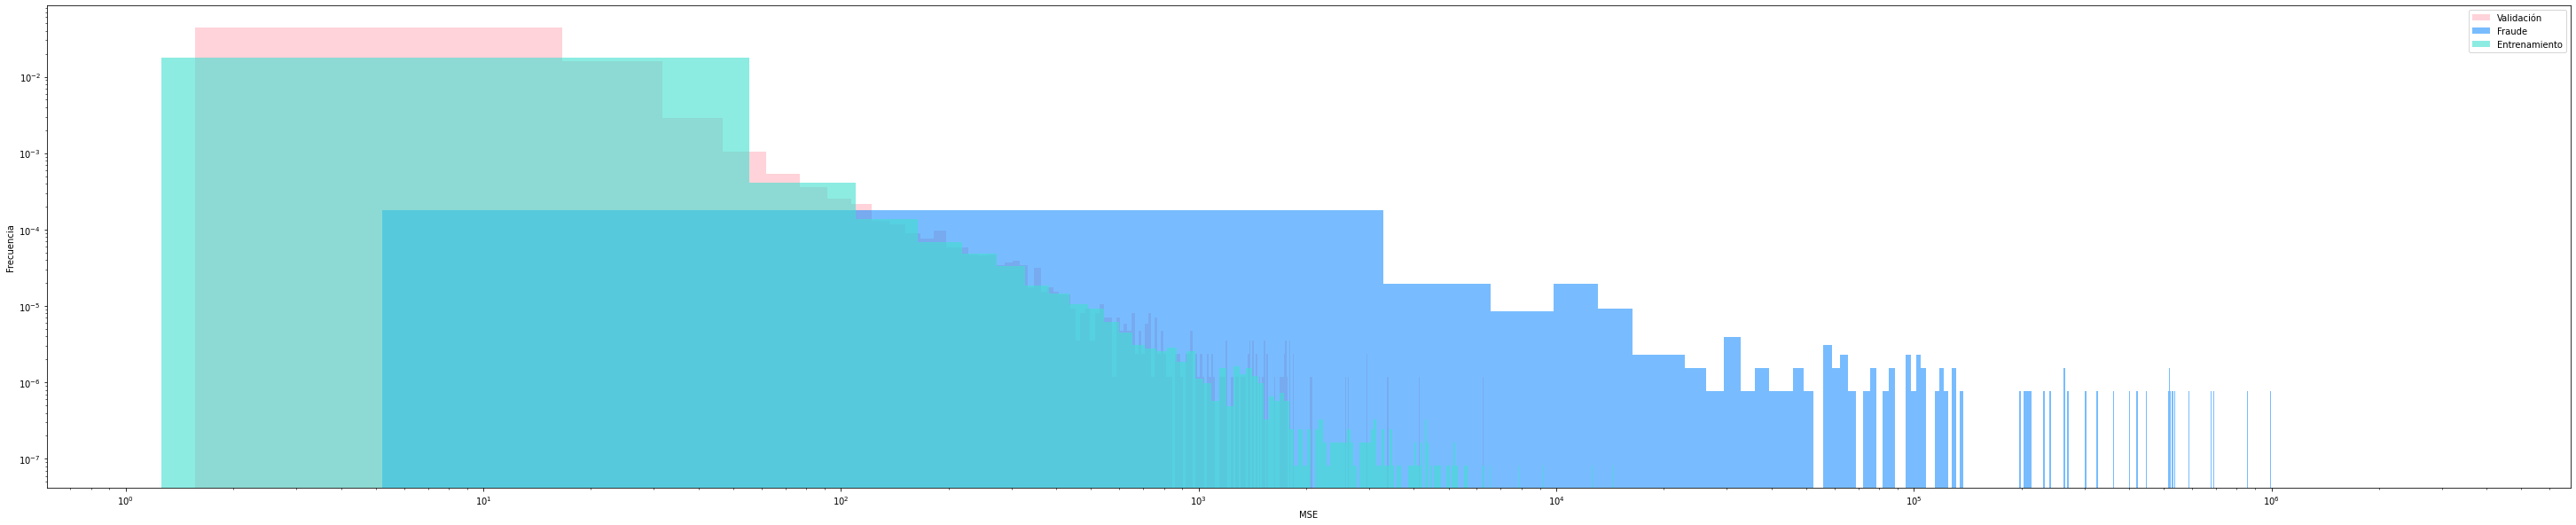

In [85]:
norm_train_recons_2 = autoencoder_2.predict(X_train)
norm_val_recons_2 = autoencoder_2.predict(X_val)
fraud_recons_2 = autoencoder_2.predict(X_fraude_train)

mse_train_2 = (np.square(norm_train_recons_2 - X_train))
mse_val_2 = (np.square(norm_val_recons_2 - X_val))
mse_fraud_2 = (np.square(fraud_recons_2 - X_fraude_train))

fig=plt.figure(figsize=(51,10))
ax=fig.add_subplot(1,1,1)
mse_val_2.sum(axis=1).hist(bins=1000,ax=ax,facecolor='lightpink',alpha=0.6,density=True,label='Validación')
mse_fraud_2.sum(axis=1).hist(bins=1000,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True,label='Fraude')
mse_train_2.sum(axis=1).hist(bins=1000,ax=ax,facecolor='turquoise',alpha=0.6,density=True,label='Entrenamiento')
ax.grid(False)
plt.ylabel('Frecuencia')
plt.xlabel('MSE')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Podemos ver que, similar al caso anterior, el comportamiento de los datos no fraudulentos en validación (rosado) y entrenamiento (turquesa) es bastante parecido. Asimismo, alrededor de MSE $\approx 100$ podemos ver que la cantidad de transacciones fraudulentas supera las no fraudulentas, similar al primer modelo.

Ahora, podemos ver que el porcentaje de transacciones no fraudulentas cuyo error cuadrático medio en entrenamiento es mayor a 100 es:

In [119]:
print('En entrenamiento: ','{} %'.format(np.round(100*len(mse_train_2[mse_train_2.sum(axis=1) >= 100])/len(mse_train_2),2)))

print('En validación: ','{} %'.format(np.round(100*len(mse_val_2[mse_val_2.sum(axis=1) >= 100])/len(mse_val_2),2)))

En entrenamiento:  2.34 %
En validación:  2.41 %


Apenas un 0.07% de diferencia. Confirmamos que no hay overfitting. En cambio, el porcentaje de transacciones fraudulentas con MSE mayor a 100 es:

In [121]:
print('Fraudulentas: ','{} %'.format(np.round(100*len(mse_fraud_2[mse_fraud_2.sum(axis=1) >= 100])/len(mse_fraud_2),2)))

Fraudulentas:  91.09 %


Vemos que, si definimos MSE$=100$, el 91.1% de las transacciones fraudulentas se catalogan como tal. Este es un porcentaje bastante bueno.

#### 2.3.3 Modelo con ajuste de hiperparámetros
Cuando estábamos creando estos modelos, pensamos mucho en cómo hacer el ajuste de hiperparámetros; pues, en realidad, no hay muchos y los que ajustábamos antes (como cantidad de capas y número de neuronas) son más difíciles de ajustar para un autoencoder. Por lo tanto, decidimos lo siguiente: consideraremos 30 neuronas por capa en la entrada, una segunda capa de 16 y (en algunos casos) una tercera capa de 8 neuronas para el encoder. Quisimos quitar esta última capa en algunos modelos porque quizá estamos reduciendo mucho la dimensionalidad del data set. No quisimos cambiar el número de neuronas por capa por la dimensión del espacio de entrada.

Los otros hiperparámetros que decidimos ajustar fueron las funciones de activación: relu, tanh y sigmoid para las capas interiores de la red, sigmoide y tanh para la de salida). Note que la función de activación de las capas del centro siempre es relu. De esta forma:

In [63]:
def entrenar_red(small_layer=True, activation_inside='relu', activation_small='relu',activation_out='tanh'):
    input_size = len(X_train.columns) 
    clf = Sequential(name='Autoencoder_CV')
    clf.add(Dense(30, activation=activation_inside, input_dim = input_size))
    if small_layer:
        clf.add(Dense(16, activation=activation_inside))
        clf.add(Dense(8, activation=activation_small))
    else:
        clf.add(Dense(16, activation=activation_small))
        
    clf.add(Dense(16, activation=activation_inside))
    clf.add(Dense(30, activation=activation_inside))
    clf.add(Dense(30, activation=activation_out))
    
    clf.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return clf

# Modelo que utiliza el GridSearch --> Usamos Keras Regressor y no Classifier por ser autoencoder.
modelCV_autoencoder = KerasRegressor(build_fn=entrenar_red, epochs=100, batch_size=500,verbose=1) # Modelo esqueleto

In [64]:
pipe = Pipeline([('autoenconder_CV', modelCV_autoencoder)]) # Creamos la pipeline

# Tomamos la grilla de hiperparametros 
param_grid = dict(
                  autoenconder_CV__small_layer = [True, False],
                  autoenconder_CV__activation_inside = ['relu', 'tanh','sigmoid'],
                  autoenconder_CV__activation_out = ['sigmoid', 'tanh'],
                  )


# Creamos la grilla
# Podriamos usar mas iteraciones en el CV, pero lo intentamos correr y se murio el kernel.
# Por eso lo redujimos
# grid_3 = RandomizedSearchCV(pipe_3, param_grid, verbose=3, cv=3, n_iter=20, random_state=28)
grid = GridSearchCV(pipe, param_grid=param_grid,scoring='neg_mean_squared_error',cv=3,verbose=3)

Para la CV, unimos los conjuntos de train y validación:

In [65]:
X_joined = pd.concat([X_train, X_val])

In [66]:
grid.fit(X_joined, X_joined, autoenconder_CV__callbacks=callbacks)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Epoch 1/100
380/380 [==============================] - 1s 1ms/step - loss: 0.9892 - mean_squared_error: 0.9892
Epoch 2/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8734 - mean_squared_error: 0.8734
Epoch 3/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8561 - mean_squared_error: 0.8561
Epoch 4/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8423 - mean_squared_error: 0.8423
Epoch 5/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8323 - mean_squared_error: 0.8323
Epoch 6/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8275 - mean_squared_error: 0.8275
Epoch 7/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8219 - mean_squared_error: 0.8219
Epoch 8/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8174 - mean_squared_error: 0.8174
Epoch 9/100
380/380 [==============================

380/380 [==============================] - 0s 991us/step - loss: 0.8034 - mean_squared_error: 0.8034
Epoch 53/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8033 - mean_squared_error: 0.8033
Epoch 54/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8030 - mean_squared_error: 0.8030
Epoch 55/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8027 - mean_squared_error: 0.8027
Epoch 56/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8026 - mean_squared_error: 0.8026
Epoch 57/100
380/380 [==============================] - 0s 999us/step - loss: 0.8022 - mean_squared_error: 0.8022
Epoch 58/100
380/380 [==============================] - 0s 939us/step - loss: 0.8023 - mean_squared_error: 0.8023
Epoch 59/100
380/380 [==============================] - 0s 997us/step - loss: 0.8019 - mean_squared_error: 0.8019
Epoch 60/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8018 - mean_squared_error: 0.80

380/380 [==============================] - 0s 1ms/step - loss: 0.7908 - mean_squared_error: 0.7908
Epoch 95/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7908 - mean_squared_error: 0.7908
Epoch 96/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7907 - mean_squared_error: 0.7907
Epoch 97/100
380/380 [==============================] - 0s 998us/step - loss: 0.7907 - mean_squared_error: 0.7907
Epoch 98/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7905 - mean_squared_error: 0.7905
Epoch 99/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7905 - mean_squared_error: 0.7905
Epoch 100/100
190/190 [==============================] - 0s 491us/step
[CV 3/3] END autoenconder_CV__activation_inside=relu, autoenconder_CV__activation_out=sigmoid, autoenconder_CV__small_layer=True;, score=-0.813 total time=  39.3s
Epoch 1/100
380/380 [==============================] - 1s 1ms/step - loss: 0.9756 - mean_squared_error: 0

Epoch 56/100
380/380 [==============================] - 0s 952us/step - loss: 0.7523 - mean_squared_error: 0.7523
Epoch 57/100
380/380 [==============================] - 0s 947us/step - loss: 0.7523 - mean_squared_error: 0.7523
Epoch 58/100
380/380 [==============================] - 0s 972us/step - loss: 0.7522 - mean_squared_error: 0.7522
Epoch 59/100
380/380 [==============================] - 0s 954us/step - loss: 0.7521 - mean_squared_error: 0.7521
Epoch 60/100
380/380 [==============================] - 0s 953us/step - loss: 0.7520 - mean_squared_error: 0.7520
Epoch 61/100
380/380 [==============================] - 0s 955us/step - loss: 0.7520 - mean_squared_error: 0.7520
Epoch 62/100
380/380 [==============================] - 0s 947us/step - loss: 0.7522 - mean_squared_error: 0.7522
Epoch 63/100
380/380 [==============================] - 0s 948us/step - loss: 0.7519 - mean_squared_error: 0.7519
Epoch 64/100
380/380 [==============================] - 0s 961us/step - loss: 0.7523 - m

Epoch 54/100
380/380 [==============================] - 0s 983us/step - loss: 0.7363 - mean_squared_error: 0.7363
Epoch 55/100
380/380 [==============================] - 0s 987us/step - loss: 0.7362 - mean_squared_error: 0.7362
Epoch 56/100
380/380 [==============================] - 0s 991us/step - loss: 0.7361 - mean_squared_error: 0.7361
Epoch 57/100
380/380 [==============================] - 0s 991us/step - loss: 0.7360 - mean_squared_error: 0.7360
Epoch 58/100
380/380 [==============================] - 0s 987us/step - loss: 0.7360 - mean_squared_error: 0.7360
Epoch 59/100
380/380 [==============================] - 0s 974us/step - loss: 0.7359 - mean_squared_error: 0.7359
Epoch 60/100
380/380 [==============================] - 0s 992us/step - loss: 0.7359 - mean_squared_error: 0.7359
Epoch 61/100
380/380 [==============================] - 0s 987us/step - loss: 0.7359 - mean_squared_error: 0.7359
Epoch 62/100
380/380 [==============================] - 0s 956us/step - loss: 0.7358 - m

380/380 [==============================] - 0s 1ms/step - loss: 0.4790 - mean_squared_error: 0.4790
Epoch 97/100
380/380 [==============================] - 0s 985us/step - loss: 0.4799 - mean_squared_error: 0.4799
Epoch 98/100
380/380 [==============================] - 0s 993us/step - loss: 0.4788 - mean_squared_error: 0.4788
Epoch 99/100
380/380 [==============================] - 0s 997us/step - loss: 0.4790 - mean_squared_error: 0.4790
Epoch 100/100
190/190 [==============================] - 0s 460us/step
[CV 1/3] END autoenconder_CV__activation_inside=relu, autoenconder_CV__activation_out=tanh, autoenconder_CV__small_layer=True;, score=-0.471 total time=  39.0s
Epoch 1/100
380/380 [==============================] - 1s 1ms/step - loss: 0.8015 - mean_squared_error: 0.8015
Epoch 2/100
380/380 [==============================] - 0s 989us/step - loss: 0.6284 - mean_squared_error: 0.6284
Epoch 3/100
380/380 [==============================] - 0s 1ms/step - loss: 0.5900 - mean_squared_error: 

380/380 [==============================] - 0s 988us/step - loss: 0.4752 - mean_squared_error: 0.4752
Epoch 37/100
380/380 [==============================] - 0s 989us/step - loss: 0.4752 - mean_squared_error: 0.4752
Epoch 38/100
380/380 [==============================] - 0s 998us/step - loss: 0.4747 - mean_squared_error: 0.4747
Epoch 39/100
380/380 [==============================] - 0s 991us/step - loss: 0.4746 - mean_squared_error: 0.4746
Epoch 40/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4741 - mean_squared_error: 0.4741
Epoch 41/100
380/380 [==============================] - 0s 984us/step - loss: 0.4740 - mean_squared_error: 0.4740
Epoch 42/100
380/380 [==============================] - 0s 997us/step - loss: 0.4738 - mean_squared_error: 0.4738
Epoch 43/100
380/380 [==============================] - 0s 989us/step - loss: 0.4736 - mean_squared_error: 0.4736
Epoch 44/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4732 - mean_squared_error

380/380 [==============================] - 0s 964us/step - loss: 0.4314 - mean_squared_error: 0.4314
Epoch 79/100
380/380 [==============================] - 0s 954us/step - loss: 0.4315 - mean_squared_error: 0.4315
Epoch 80/100
380/380 [==============================] - 0s 955us/step - loss: 0.4314 - mean_squared_error: 0.4314
Epoch 81/100
380/380 [==============================] - 0s 952us/step - loss: 0.4314 - mean_squared_error: 0.4314
Epoch 00081: early stopping
190/190 [==============================] - 0s 488us/step
[CV 1/3] END autoenconder_CV__activation_inside=relu, autoenconder_CV__activation_out=tanh, autoenconder_CV__small_layer=False;, score=-0.423 total time=  30.3s
Epoch 1/100
380/380 [==============================] - 1s 1ms/step - loss: 0.7672 - mean_squared_error: 0.7672
Epoch 2/100
380/380 [==============================] - 0s 966us/step - loss: 0.5696 - mean_squared_error: 0.5696
Epoch 3/100
380/380 [==============================] - 0s 956us/step - loss: 0.5176 - m

380/380 [==============================] - 0s 974us/step - loss: 0.4052 - mean_squared_error: 0.4052
Epoch 37/100
380/380 [==============================] - 0s 965us/step - loss: 0.4051 - mean_squared_error: 0.4051
Epoch 38/100
380/380 [==============================] - 0s 945us/step - loss: 0.4049 - mean_squared_error: 0.4049
Epoch 39/100
380/380 [==============================] - 0s 947us/step - loss: 0.4047 - mean_squared_error: 0.4047
Epoch 40/100
380/380 [==============================] - 0s 953us/step - loss: 0.4046 - mean_squared_error: 0.4046
Epoch 41/100
380/380 [==============================] - 0s 952us/step - loss: 0.4046 - mean_squared_error: 0.4046
Epoch 42/100
380/380 [==============================] - 0s 958us/step - loss: 0.4043 - mean_squared_error: 0.4043
Epoch 43/100
380/380 [==============================] - 0s 952us/step - loss: 0.4043 - mean_squared_error: 0.4043
Epoch 44/100
380/380 [==============================] - 0s 936us/step - loss: 0.4041 - mean_squared_e

380/380 [==============================] - 0s 1ms/step - loss: 0.8091 - mean_squared_error: 0.8091
Epoch 10/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8051 - mean_squared_error: 0.8051
Epoch 11/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8017 - mean_squared_error: 0.8017
Epoch 12/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7987 - mean_squared_error: 0.7987
Epoch 13/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7962 - mean_squared_error: 0.7962
Epoch 14/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7941 - mean_squared_error: 0.7941
Epoch 15/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7922 - mean_squared_error: 0.7922
Epoch 16/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7905 - mean_squared_error: 0.7905
Epoch 17/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7890 - mean_squared_error: 0.7890
Epoch

380/380 [==============================] - 0s 1ms/step - loss: 0.7669 - mean_squared_error: 0.7669
Epoch 54/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7667 - mean_squared_error: 0.7667
Epoch 55/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7666 - mean_squared_error: 0.7666
Epoch 56/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7664 - mean_squared_error: 0.7664
Epoch 57/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7663 - mean_squared_error: 0.7663
Epoch 58/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7661 - mean_squared_error: 0.7661
Epoch 59/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7660 - mean_squared_error: 0.7660
Epoch 60/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7659 - mean_squared_error: 0.7659
Epoch 61/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7658 - mean_squared_error: 0.7658
Epoch

380/380 [==============================] - 0s 1ms/step - loss: 0.7548 - mean_squared_error: 0.7548
Epoch 98/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7547 - mean_squared_error: 0.7547
Epoch 99/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7547 - mean_squared_error: 0.7547
Epoch 100/100
190/190 [==============================] - 0s 506us/step
[CV 3/3] END autoenconder_CV__activation_inside=tanh, autoenconder_CV__activation_out=sigmoid, autoenconder_CV__small_layer=True;, score=-0.778 total time=  41.3s
Epoch 1/100
380/380 [==============================] - 1s 1ms/step - loss: 1.0092 - mean_squared_error: 1.0092
Epoch 2/100
380/380 [==============================] - 0s 999us/step - loss: 0.8869 - mean_squared_error: 0.8869
Epoch 3/100
380/380 [==============================] - 0s 984us/step - loss: 0.8455 - mean_squared_error: 0.8455
Epoch 4/100
380/380 [==============================] - 0s 973us/step - loss: 0.8201 - mean_squared_error: 

Epoch 41/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7322 - mean_squared_error: 0.7322
Epoch 42/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7320 - mean_squared_error: 0.7320
Epoch 43/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7318 - mean_squared_error: 0.7318
Epoch 44/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7316 - mean_squared_error: 0.7316
Epoch 45/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7314 - mean_squared_error: 0.7314
Epoch 46/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7312 - mean_squared_error: 0.7312
Epoch 47/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7311 - mean_squared_error: 0.7311
Epoch 48/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7309 - mean_squared_error: 0.7309
Epoch 49/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7308 - mean_squared_error:

380/380 [==============================] - 0s 1ms/step - loss: 0.7515 - mean_squared_error: 0.7515
Epoch 13/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7488 - mean_squared_error: 0.7488
Epoch 14/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7466 - mean_squared_error: 0.7466
Epoch 15/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7448 - mean_squared_error: 0.7448
Epoch 16/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7432 - mean_squared_error: 0.7432
Epoch 17/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7419 - mean_squared_error: 0.7419
Epoch 18/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7408 - mean_squared_error: 0.7408
Epoch 19/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7399 - mean_squared_error: 0.7399
Epoch 20/100
380/380 [==============================] - 0s 1ms/step - loss: 0.7390 - mean_squared_error: 0.7390
Epoch

380/380 [==============================] - 0s 1ms/step - loss: 0.4530 - mean_squared_error: 0.4530
Epoch 57/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4525 - mean_squared_error: 0.4525
Epoch 58/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4521 - mean_squared_error: 0.4521
Epoch 59/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4516 - mean_squared_error: 0.4516
Epoch 60/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4513 - mean_squared_error: 0.4513
Epoch 61/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4512 - mean_squared_error: 0.4512
Epoch 62/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4509 - mean_squared_error: 0.4509
Epoch 63/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4506 - mean_squared_error: 0.4506
Epoch 64/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4503 - mean_squared_error: 0.4503
Epoch

190/190 [==============================] - 0s 502us/step
[CV 2/3] END autoenconder_CV__activation_inside=tanh, autoenconder_CV__activation_out=tanh, autoenconder_CV__small_layer=True;, score=-0.450 total time=  40.9s
Epoch 1/100
380/380 [==============================] - 1s 1ms/step - loss: 0.7796 - mean_squared_error: 0.7796
Epoch 2/100
380/380 [==============================] - 0s 1ms/step - loss: 0.6469 - mean_squared_error: 0.6469
Epoch 3/100
380/380 [==============================] - 0s 1ms/step - loss: 0.6048 - mean_squared_error: 0.6048
Epoch 4/100
380/380 [==============================] - 0s 1ms/step - loss: 0.5818 - mean_squared_error: 0.5818
Epoch 5/100
380/380 [==============================] - 0s 1ms/step - loss: 0.5649 - mean_squared_error: 0.5649
Epoch 6/100
380/380 [==============================] - 0s 1ms/step - loss: 0.5518 - mean_squared_error: 0.5518
Epoch 7/100
380/380 [==============================] - 0s 1ms/step - loss: 0.5408 - mean_squared_error: 0.5408
Epoch 

380/380 [==============================] - 0s 1ms/step - loss: 0.4199 - mean_squared_error: 0.4199
Epoch 42/100
380/380 [==============================] - 0s 934us/step - loss: 0.4196 - mean_squared_error: 0.4196
Epoch 43/100
380/380 [==============================] - 0s 986us/step - loss: 0.4193 - mean_squared_error: 0.4193
Epoch 44/100
380/380 [==============================] - 0s 979us/step - loss: 0.4189 - mean_squared_error: 0.4189
Epoch 45/100
380/380 [==============================] - 0s 992us/step - loss: 0.4187 - mean_squared_error: 0.4187
Epoch 46/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4184 - mean_squared_error: 0.4184
Epoch 47/100
380/380 [==============================] - 0s 1ms/step - loss: 0.4181 - mean_squared_error: 0.4181
Epoch 48/100
380/380 [==============================] - 0s 996us/step - loss: 0.4180 - mean_squared_error: 0.4180
Epoch 49/100
380/380 [==============================] - 0s 990us/step - loss: 0.4175 - mean_squared_error: 

380/380 [==============================] - 0s 1000us/step - loss: 0.4023 - mean_squared_error: 0.4023
Epoch 84/100
380/380 [==============================] - 0s 992us/step - loss: 0.4022 - mean_squared_error: 0.4022
Epoch 85/100
380/380 [==============================] - 0s 980us/step - loss: 0.4020 - mean_squared_error: 0.4020
Epoch 86/100
380/380 [==============================] - 0s 993us/step - loss: 0.4019 - mean_squared_error: 0.4019
Epoch 87/100
380/380 [==============================] - 0s 992us/step - loss: 0.4018 - mean_squared_error: 0.4018
Epoch 88/100
380/380 [==============================] - 0s 993us/step - loss: 0.4017 - mean_squared_error: 0.4017
Epoch 89/100
380/380 [==============================] - 0s 989us/step - loss: 0.4017 - mean_squared_error: 0.4017
Epoch 90/100
380/380 [==============================] - 0s 987us/step - loss: 0.4015 - mean_squared_error: 0.4015
Epoch 91/100
380/380 [==============================] - 0s 975us/step - loss: 0.4015 - mean_squared_

Epoch 24/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8974 - mean_squared_error: 0.8974
Epoch 25/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8932 - mean_squared_error: 0.8932
Epoch 26/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8904 - mean_squared_error: 0.8904
Epoch 27/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8883 - mean_squared_error: 0.8883
Epoch 28/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8864 - mean_squared_error: 0.8864
Epoch 29/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8846 - mean_squared_error: 0.8846
Epoch 30/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8830 - mean_squared_error: 0.8830
Epoch 31/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8815 - mean_squared_error: 0.8815
Epoch 32/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8801 - mean_squared_error:

380/380 [==============================] - 0s 1ms/step - loss: 0.8417 - mean_squared_error: 0.8417
Epoch 69/100
380/380 [==============================] - 1s 2ms/step - loss: 0.8413 - mean_squared_error: 0.8413
Epoch 70/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8409 - mean_squared_error: 0.8409
Epoch 71/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8405 - mean_squared_error: 0.8405
Epoch 72/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8402 - mean_squared_error: 0.8402
Epoch 73/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8398 - mean_squared_error: 0.8398
Epoch 74/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8394 - mean_squared_error: 0.8394
Epoch 75/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8391 - mean_squared_error: 0.8391
Epoch 76/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8387 - mean_squared_error: 0.8387
Epoch

380/380 [==============================] - 2s 5ms/step - loss: 0.8931 - mean_squared_error: 0.8931
Epoch 11/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8828 - mean_squared_error: 0.8828
Epoch 12/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8713 - mean_squared_error: 0.8713
Epoch 13/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8618 - mean_squared_error: 0.8618
Epoch 14/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8552 - mean_squared_error: 0.8552
Epoch 15/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8486 - mean_squared_error: 0.8486
Epoch 16/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8404 - mean_squared_error: 0.8404
Epoch 17/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8302 - mean_squared_error: 0.8302
Epoch 18/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8235 - mean_squared_error: 0.8235
Epoch

380/380 [==============================] - 1s 4ms/step - loss: 0.7596 - mean_squared_error: 0.7596
Epoch 55/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7591 - mean_squared_error: 0.7591
Epoch 56/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7586 - mean_squared_error: 0.7586
Epoch 57/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7581 - mean_squared_error: 0.7581
Epoch 58/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7576 - mean_squared_error: 0.7576
Epoch 59/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7571 - mean_squared_error: 0.7571
Epoch 60/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7567 - mean_squared_error: 0.7567
Epoch 61/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7562 - mean_squared_error: 0.7562
Epoch 62/100
380/380 [==============================] - 1s 4ms/step - loss: 0.7559 - mean_squared_error: 0.7559
Epoch

380/380 [==============================] - 2s 5ms/step - loss: 0.7386 - mean_squared_error: 0.7386
Epoch 99/100
380/380 [==============================] - 2s 5ms/step - loss: 0.7384 - mean_squared_error: 0.7384
Epoch 100/100
190/190 [==============================] - 1s 3ms/step
[CV 3/3] END autoenconder_CV__activation_inside=sigmoid, autoenconder_CV__activation_out=sigmoid, autoenconder_CV__small_layer=False;, score=-0.761 total time= 2.9min
Epoch 1/100
380/380 [==============================] - 3s 5ms/step - loss: 1.0120 - mean_squared_error: 1.0120
Epoch 2/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8943 - mean_squared_error: 0.8943
Epoch 3/100
380/380 [==============================] - 2s 5ms/step - loss: 0.8187 - mean_squared_error: 0.8187
Epoch 4/100
380/380 [==============================] - 2s 5ms/step - loss: 0.7794 - mean_squared_error: 0.7794
Epoch 5/100
380/380 [==============================] - 2s 5ms/step - loss: 0.7570 - mean_squared_error: 0.757

380/380 [==============================] - 2s 5ms/step - loss: 0.5645 - mean_squared_error: 0.5645
Epoch 41/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5632 - mean_squared_error: 0.5632
Epoch 42/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5620 - mean_squared_error: 0.5620
Epoch 43/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5609 - mean_squared_error: 0.5609
Epoch 44/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5597 - mean_squared_error: 0.5597
Epoch 45/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5587 - mean_squared_error: 0.5587
Epoch 46/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5577 - mean_squared_error: 0.5577
Epoch 47/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5566 - mean_squared_error: 0.5566
Epoch 48/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5557 - mean_squared_error: 0.5557
Epoch

380/380 [==============================] - 2s 5ms/step - loss: 0.5207 - mean_squared_error: 0.5207
Epoch 85/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5203 - mean_squared_error: 0.5203
Epoch 86/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5200 - mean_squared_error: 0.5200
Epoch 87/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5196 - mean_squared_error: 0.5196
Epoch 88/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5193 - mean_squared_error: 0.5193
Epoch 89/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5190 - mean_squared_error: 0.5190
Epoch 90/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5187 - mean_squared_error: 0.5187
Epoch 91/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5184 - mean_squared_error: 0.5184
Epoch 92/100
380/380 [==============================] - 2s 5ms/step - loss: 0.5181 - mean_squared_error: 0.5181
Epoch

380/380 [==============================] - 2s 5ms/step - loss: 0.5006 - mean_squared_error: 0.5006
Epoch 27/100
380/380 [==============================] - 2s 5ms/step - loss: 0.4987 - mean_squared_error: 0.4987
Epoch 28/100
380/380 [==============================] - 2s 5ms/step - loss: 0.4970 - mean_squared_error: 0.4970
Epoch 29/100
380/380 [==============================] - 2s 5ms/step - loss: 0.4953 - mean_squared_error: 0.4953
Epoch 30/100
380/380 [==============================] - 2s 4ms/step - loss: 0.4935 - mean_squared_error: 0.4935
Epoch 31/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4915 - mean_squared_error: 0.4915
Epoch 32/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4892 - mean_squared_error: 0.4892
Epoch 33/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4867 - mean_squared_error: 0.4867
Epoch 34/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4838 - mean_squared_error: 0.4838
Epoch

380/380 [==============================] - 2s 5ms/step - loss: 0.4290 - mean_squared_error: 0.4290
Epoch 71/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4281 - mean_squared_error: 0.4281
Epoch 72/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4273 - mean_squared_error: 0.4273
Epoch 73/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4264 - mean_squared_error: 0.4264
Epoch 74/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4257 - mean_squared_error: 0.4257
Epoch 75/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4250 - mean_squared_error: 0.4250
Epoch 76/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4243 - mean_squared_error: 0.4243
Epoch 77/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4238 - mean_squared_error: 0.4238
Epoch 78/100
380/380 [==============================] - 1s 4ms/step - loss: 0.4232 - mean_squared_error: 0.4232
Epoch

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('autoenconder_CV',
                                        <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fee3bebf520>)]),
             param_grid={'autoenconder_CV__activation_inside': ['relu', 'tanh',
                                                                'sigmoid'],
                         'autoenconder_CV__activation_out': ['sigmoid', 'tanh'],
                         'autoenconder_CV__small_layer': [True, False]},
             scoring='neg_mean_squared_error', verbose=3)

Revisamos cuál es el mejor modelo:

In [69]:
best_model_autoencoder = grid.best_estimator_
best_model_autoencoder['autoenconder_CV'].model.summary()

Model: "Autoencoder_CV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_231 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_232 (Dense)            (None, 16)                496       
_________________________________________________________________
dense_233 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_234 (Dense)            (None, 30)                510       
_________________________________________________________________
dense_235 (Dense)            (None, 30)                930       
Total params: 3,138
Trainable params: 3,138
Non-trainable params: 0
_________________________________________________________________


# TO DO: ¿Cuáles funciones de activación?

¡Podemos ver que se eligió el modelo sin la capa de 8 neuronas! Veamos el resultado del MSE

In [71]:
best_score_autoencoder = np.abs(grid.best_score_)
print('El MSE del mejor modelo para el autoencoder es: ', best_score_autoencoder)

El MSE del mejor modelo para el autoencoder es:  0.4003763884796426


De igual forma que para los otros modelos, graficamos el MSE para los datos de entrenamiento y comparamos con los de validación, con el fin de revisar que no haya overfitting (i.e. obteniendo distribuciones similares). Asimismo, revisamos con las transacciones fraudulentas a ver si no se están reconstruyendo bien (i.e. son anómalas).

1/1 [==============================] - 0s 9ms/step


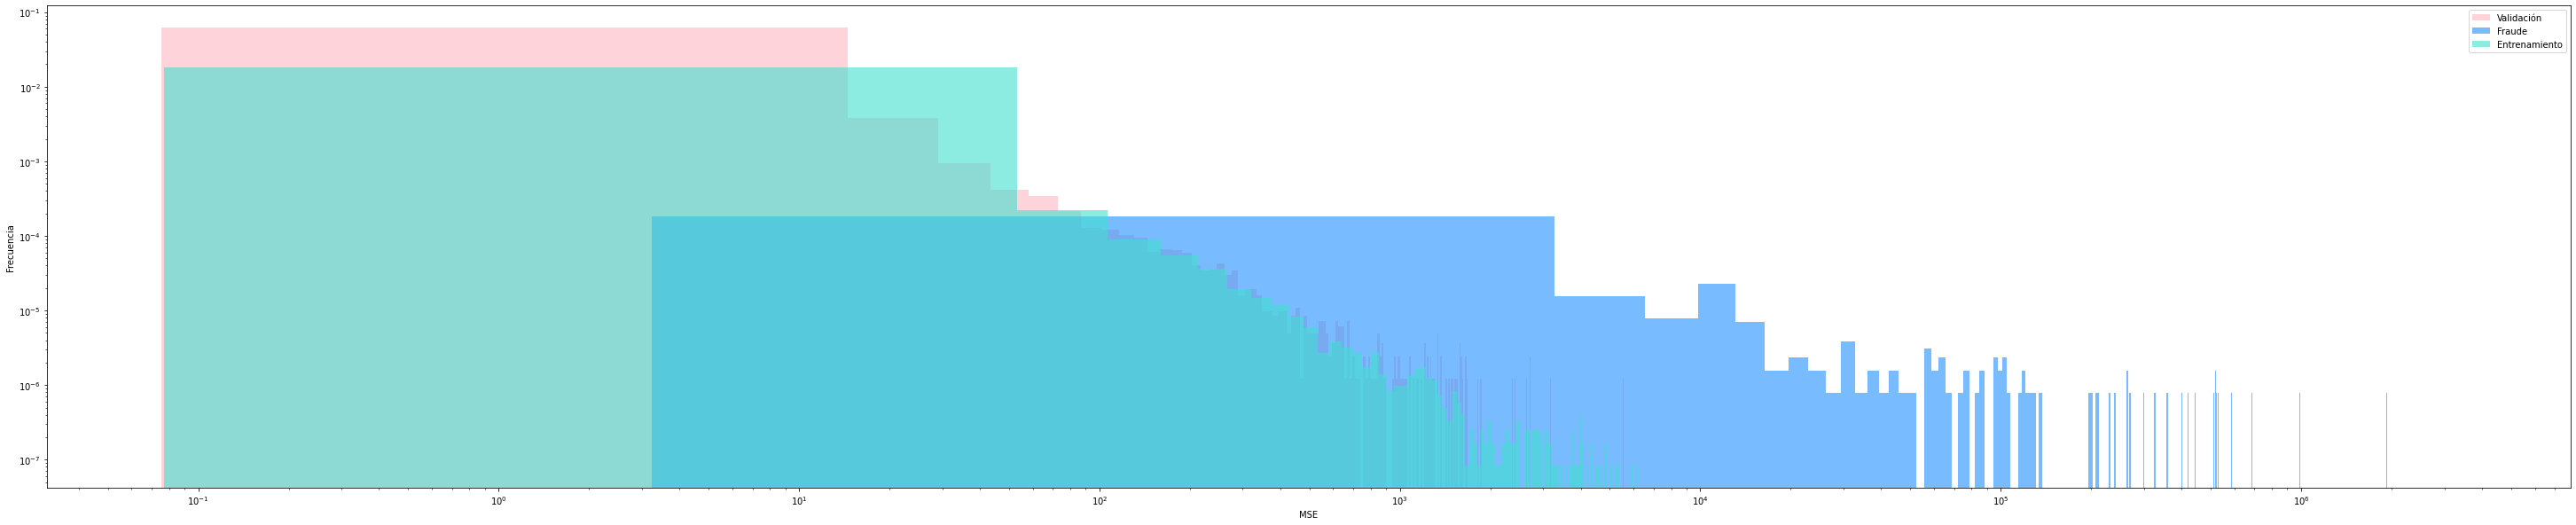

In [82]:
norm_train_recons_3 = best_model_autoencoder.predict(X_train)
norm_val_recons_3 = best_model_autoencoder.predict(X_val)
fraud_recons_3 = best_model_autoencoder.predict(X_fraude_train)

mse_train_3 = (np.square(norm_train_recons_3 - X_train))
mse_val_3 = (np.square(norm_val_recons_3 - X_val))
mse_fraud_3 = (np.square(fraud_recons_3 - X_fraude_train))

fig=plt.figure(figsize=(51,10))
ax=fig.add_subplot(1,1,1)
mse_val_3.sum(axis=1).hist(bins=1000,ax=ax,facecolor='lightpink',alpha=0.6,density=True,label='Validación')
mse_fraud_3.sum(axis=1).hist(bins=1000,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True,label='Fraude')
mse_train_3.sum(axis=1).hist(bins=1000,ax=ax,facecolor='turquoise',alpha=0.6,density=True,label='Entrenamiento')
ax.grid(False)
plt.ylabel('Frecuencia')
plt.xlabel('MSE')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Podemos ver una tendencia similar a las dos gráficas estudiadas previamente: tanto entrenamiento como validación siguen una tendencia similar en su MSE y la cantidad de transacciones fraudulentas supera a las no fraudulentas alrededor de MSE $\approx100$.

Asimismo, podemos ver que el porcentaje de transacciones no fraudulentas cuyo error cuadrático medio en entrenamiento es mayor a 100 es:

In [116]:
print('En entrenamiento: ','{} %'.format(np.round(100*len(mse_train_3[mse_train_3.sum(axis=1) >= 100])/len(mse_train_3),2)))

En entrenamiento:  1.58 %


In [117]:
print('En validación: ','{} %'.format(np.round(100*len(mse_val_3[mse_val_3.sum(axis=1) >= 100])/len(mse_val_3),2)))

En validación:  1.63 %


¡Apenas un 0.05% de diferencia! En cambio, el porcentaje de transacciones fraudulentas con MSE mayor a 100 es:

In [118]:
print('Fraudulentas: ','{} %'.format(np.round(100*len(mse_fraud_3[mse_fraud_3.sum(axis=1) >= 100])/len(mse_fraud_3),2)))

Fraudulentas:  87.02 %


El 87.02% de las transacciones fraudulentas se cataloga como tal si definimos el threshold en MSE$ = 100$. Esto es un número bastante bueno. Podemos incluso aumentarlo si disminuimos un poco el MSE, considerando que apenas $\approx 1.6$% de las transacciones no fraudulentas se catalogan como fraudulentas.

#### 2.3.4 Definición de los thresholds y escogencia del modelo

Podemos redefinir el threshold de MSE=$100$, a aproximadamente el 2% de las transacciones no fraudulentas catalogadas como fraudulentas; pues, como vimos previamente, son _casi_ equivalentes. De esta forma, tenemos que los porcentajes de transacciones fraudulentas catalogadas adecuadamente son:

In [126]:
print('Modelo baseline 1: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud.sum(axis=1), np.percentile(mse_train.sum(axis=1),98, interpolation="linear"), kind="mean"),2))) 

Modelo baseline 1:  91.09 %


In [127]:
print('Modelo baseline 2: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud_2.sum(axis=1), np.percentile(mse_train_2.sum(axis=1),98, interpolation="linear"), kind="mean"),2))) 

Modelo baseline 2:  90.08 %


In [128]:
print('Modelo con CV: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud_3.sum(axis=1), np.percentile(mse_train_3.sum(axis=1),98, interpolation="linear"), kind="mean"),2))) 

Modelo con CV:  90.59 %


En general, podemos ver que los tres porcentajes obtenidos son bastante similares: apenas difieren en máximo 1%. No obstante, el modelo que parece dar mejores resultados es el baseline 1, seguido del que tuneamos con cross validation. Por lo tanto, en un escenario en que tuviéramos que elegir uno sólo, escogeríamos el baseline 1. No obstante, también nos gustaría ver qué pasa con el de CV (pues se eligió uno con una capa menos que el baseline, con una tasa de detección de transacciones fraudulentas bastante similar.

Lo que queremos ahora es maximizar la cantidad de transacciones fraudulentas, así se nos cataloguen unas pocas (2%) transacciones normales como fraudulentas (i.e. falsos positivos). Seguramente, si aumentamos la tolerancia del 2% a, por ejemplo, el 5%, incrementaremos la cantidad de transacciones fraudulentas correctamente clasificadas (pero estaremos sacrificando las no fraudulentas). No obstante, el 5% puede ser un valor adecuado de threshold. Veamos qué pasa si tomamos este threshold para el modelo baseline 1 y el que tuneamos con CV:

In [129]:
print('Modelo baseline 1: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud.sum(axis=1), np.percentile(mse_train.sum(axis=1),95, interpolation="linear"), kind="mean"),2))) 

Modelo baseline 1:  94.4 %


In [130]:
print('Modelo con CV: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud_3.sum(axis=1), np.percentile(mse_train_3.sum(axis=1),95, interpolation="linear"), kind="mean"),2))) 

Modelo con CV:  96.18 %


Si aumentamos la tolerancia, parece que el modelo que tuneamos con cross validation tiene mejor reconocimiento de transacciones fraudulentas. Esto sucede cuando apenas el 5% (i.e. 11373 transacciones normales) se catalogan como fraudulentas, y se nos escapan apenas 15 transacciones fraudulentas (3.82%). ¡Es un buen indicio! Probemos ahora el despliegue para ver qué tan bien está nuestro modelo.

### 2.4 Despliegue del modelo

Recordemos que el test es únicamente de transacciones fraudulentas. ¡Veamos qué tan bien quedaron clasificadas! Antes de eso, debemos escalar las variables de Amount y Time con el <code>StandardScaler()</code>, como hicimos en entrenamiento y validación.

Note que aquí no tenemos transacciones normales, pues realmente ya vimos que todos los modelos se comportan bien con ellas, como vimos previamente en los conjuntos de validación que destinamos. Pensamos que en despliegue es únicamente relevante revisar transacciones fraudulentas que el modelo no haya visto aún. 